# Analysis of PISA Pizzorusso LAB Data

This Python script performs statistical analysis on experimental data related to cell counts, density, and energy levels across different experimental groups. The script includes data loading, statistical testing, correlation analysis, and visualization of the results.

## Table of Contents

- [Requirements](#requirements)
- [Usage](#usage)
- [Functions](#functions)
- [Statistical Analysis](#statistical-analysis)
  - [Data Loading](#data-loading)
  - [Group Division](#group-division)
  - [Statistical Tests](#statistical-tests)
  - [Significance Detection](#significance-detection)
  - [Correlation Analysis](#correlation-analysis)
  - [Behavioral Data Analysis](#behavioral-data-analysis)
- [Visualization](#visualization)

## Usage

1. Modify the `root_directory`, `experiment`, and `experimental_group` paths to point to your local directories.
2. Load the necessary query files and experimental data.
3. Run the script to perform statistical tests, find significant areas, and generate visualizations.

### Data Files

- CSV files containing mouse data (e.g., `cells.csv`).
- Pre-processed `npy` files containing results across mice.
- Excel files with behavioral data.

## Functions

### `load_subject(subject, data_directory)`

Loads data for a specific subject from the provided directory.

- **Parameters:**
  - `subject` (str): The subject ID.
  - `data_directory` (str): Path to the directory containing subject data.

- **Returns:**
  - `df_mouse` (DataFrame): Reformatted mouse data.

### `find_significant_areas(dictionary, experimental_groups, value, test='mannwhitneyu', alpha=0.05)`

Performs statistical tests across experimental groups and identifies areas with significant differences.

- **Parameters:**
  - `dictionary` (dict): Data for multiple subjects.
  - `experimental_groups` (dict): Dictionary defining experimental groups.
  - `value` (str): The variable to be tested (e.g., `n_cells`, `density`, `energy`).
  - `test` (str): Statistical test to perform (`mannwhitneyu`, `ttest_ind`).
  - `alpha` (float): Significance threshold.

- **Returns:**
  - `df_sigareas` (DataFrame): DataFrame with significant areas.

## Statistical Analysis

### Data Loading

The script loads mouse-specific data from CSV files using `load_subject`. Results across all mice are loaded from a pre-processed dictionary of volumes.

### Group Division

The experimental groups are divided using the `utils.divide_in_exp_groups` function. The three groups in the analysis are:

- `noshock`: Control group with no shocks.
- `demonstrator`: Mice that received a demonstration.
- `observer`: Mice that observed the demonstration.

### Statistical Tests

The script performs non-parametric statistical tests (e.g., Mann-Whitney U) to compare cell counts, density, and energy levels across the experimental groups.

The key comparisons include:

- `noshock` vs. `demonstrator`
- `noshock` vs. `observer`
- `demonstrator` vs. `observer`

### Significance Detection

The script identifies areas with significant differences in cell count, density, and energy based on the p-values of the statistical tests. Significant areas are saved as CSV files.

### Correlation Analysis

Correlation matrices are computed for the following measures across the experimental groups:

- Number of cells (`n_cells`)
- Density
- Energy
- Relative density

Pearson correlation coefficients are calculated and visualized using heatmaps.

### Behavioral Data Analysis

The script loads behavioral data related to pupil amplitude (`EC_amp_0`) and latency (`EC_lat_0`) from an Excel file. Correlation analyses are performed between these behavioral measures and the number of cells in significant brain areas.

## Visualization

The script generates the following visualizations:

1. **Heatmaps** of correlation matrices for different experimental groups (e.g., `noshock`, `observer`).
2. **Scatter plots** and regression lines showing the relationship between cell count and behavioral measures (e.g., pupil amplitude).
3. **Histograms** of correlation coefficients and count distributions for significant areas.

### Example Plots

- **Correlation Heatmaps**: Display correlations across different experimental groups.
- **Behavior vs. Cell Count Scatterplots**: Show relationships between behavioral measures (e.g., `EC_amp_0`) and cell count in specific brain areas.

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import scipy.stats

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'PISA'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'

In [4]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [5]:
def load_subject(subject, data_directory):
    file_suffix = 'cells'
    df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

In [6]:
def find_significant_areas(dictionary, experimental_groups, value, test='mannwhitneyu', alpha=0.05):
    """
    Identify significant areas based on statistical testing across experimental groups.

    This function performs a non-parametric statistical test (e.g., Mann-Whitney U) 
    across experimental groups to identify areas that show significant differences
    for a specified value (e.g., 'n_cells'). It returns a DataFrame containing the 
    areas with significant p-values.

    Parameters:
    dictionary (dict): Dictionary containing data for multiple mice.
    experimental_groups (dict): Dictionary defining the experimental groups.
    value (str): The key in the dictionary whose values will be compared across groups.
    test (str): The statistical test to use (default is 'mannwhitneyu').
    alpha (float): The significance level for the test (default is 0.05).

    Returns:
    pd.DataFrame: A DataFrame containing significant areas with their p-values.
    """
    
    # Calculate the specified value across experimental groups
    dfs = ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                            dict_results_across_mice=dictionary, 
                                            value=value)
    
    # Perform statistical tests across the groups
    df_ttest = ace.test_across_groups(dfs, test=test, groups=list(experimental_groups.keys()))

    # Extract the column names corresponding to p-values
    columns = df_ttest.loc[:, df_ttest.columns != 'area'].columns

    # Initialize an empty DataFrame to store significant areas
    df_sigareas = pd.DataFrame()

    # Iterate through each p-value column to identify significant areas
    for col in columns:
        # Sort the DataFrame by the p-value column and select the areas with significant p-values
        df = df_ttest.sort_values(by=col)[['area', col]]
        df_sigareas = pd.concat([df_sigareas, df[df[col] < alpha]['area'].reset_index(drop=True)], axis=1)
    
    # Rename the columns to remove 'pval_' prefix
    df_sigareas.columns = [col.replace('pval_', '') for col in columns]

    return df_sigareas

In [7]:
# #NB: Run only if file does not exist or needs to be regenerated
# dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject=subject,
#                                                                                                data_directory=data_directory), 
#                                                                           vol=volumes, 
#                                                                           level=8,
#                                       macroareas_to_remove=['Medulla', 'Cerebellar cortex', 'Cerebellar nuclei', 'Pons']) for subject in subjects}
# np.save('dict_results/newvolumes/dict_results_across_mice_PISA_without_Pons.npy', dict_results_across_mice)

In [8]:
dict_results_across_mice = np.load('./dict_results/newvolumes/dict_results_across_mice_PISA_without_Pons.npy', 
                                   allow_pickle=True).item()

# reformat dictionary and subjects
def reformat_dict(dict_results_across_mice):
    old_keys = list(dict_results_across_mice.keys())
    for key in old_keys:
        group = key.split('_')[-1] if key.split('_')[-1][-1]!='2' else key.split('_')[-1][:-1]
        number = key.split('_')[0]
        new_key = 'BL'+number+group
        dict_results_across_mice[new_key] = dict_results_across_mice[key]
        del dict_results_across_mice[key]
    return dict_results_across_mice

dict_results_across_mice = reformat_dict(dict_results_across_mice=dict_results_across_mice)

#remove subject
del dict_results_across_mice['BL12noshock']

subjects = list(dict_results_across_mice.keys())

In [9]:
# saving data
# for subject in subjects:
#     dict_results_across_mice[subject].to_csv(data_directory+subject+'.csv', 
#                                        index=False)

In [9]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects,
                                                group_labels=['noshock','demonstrator', 'observer'])

In [10]:
df_noshock_ncells, df_demonstrator_ncells, df_observer_ncells = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

# Calculate t-tests number of cell across groups per area

In [11]:
df_noshock_ncells, df_demonstrator_ncells, df_observer_ncells = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups([df_noshock_ncells,
                                          df_demonstrator_ncells,
                                          df_observer_ncells],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'],
                                        test='mannwhitneyu')

In [13]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='density',
                       test='mannwhitneyu',
                      alpha=0.01)

,noshock_vs_demonstrator,noshock_vs_observer,demonstrator_vs_observer
0,Suprachiasmatic preoptic nucleus,Posterolateral visual area,Nucleus circularis
1,Substantia nigra lateral part,Dorsomedial nucleus of the hypothalamus,Anterior hypothalamic area
2,Lateral strip of striatum,Substantia nigra lateral part,Substantia nigra lateral part
3,Retroethmoid nucleus,Intercollicular nucleus,Lateral strip of striatum
4,Intercollicular nucleus,Suprachiasmatic preoptic nucleus,Suprachiasmatic preoptic nucleus
5,Anterior hypothalamic area,Anterior hypothalamic area,Retroethmoid nucleus
6,Nucleus circularis,Lateral strip of striatum,Intercollicular nucleus
7,Pineal body,Retroethmoid nucleus,Pineal body
8,Taenia tecta,Nucleus circularis,NaN
9,Cortical amygdalar area,Pineal body,NaN


In [14]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all')

In [15]:
#sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_noshock_vs_demonstrator')[['area', 'pval_noshock_vs_demonstrator']][0:20].set_index('area')

,pval_noshock_vs_demonstrator
area,
Taenia tecta,0.00246895
Cortical amygdalar area,0.00246895
Piriform area,0.00246895
Posterolateral visual area,0.00361311
Anterior olfactory nucleus,0.00364518
Claustrum,0.00530167
Piriform-amygdalar area,0.00530167
Basomedial amygdalar nucleus,0.0075968
Anteromedial visual area,0.0075968


In [16]:
#sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_noshock_vs_observer')[['area', 'pval_noshock_vs_observer']][0:30].set_index('area')

,pval_noshock_vs_observer
area,
Posterolateral visual area,0.00107035
Parataenial nucleus,0.00108251
Dorsomedial nucleus of the hypothalamus,0.00108251
Anterior olfactory nucleus,0.00164726
Taenia tecta,0.00164726
Retrosplenial area,0.00164726
Anteromedial visual area,0.00246895
Lateral visual area,0.00246895
Basomedial amygdalar nucleus,0.00246895


In [17]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_demonstrator_vs_observer')[['area', 'pval_demonstrator_vs_observer']][0:10].set_index('area')

,pval_demonstrator_vs_observer
area,
Preparasubthalamic nucleus,0.0483488
Pedunculopontine nucleus,0.0626005
Lateral habenula,0.0626005
Globus pallidus internal segment,0.0626005
Ventral tegmental area,0.0799321
Midbrain reticular nucleus retrorubral area,0.0799321
Perireunensis nucleus,0.100172
Intermediodorsal nucleus of the thalamus,0.100668
Peripeduncular nucleus,0.100668


# Correlations across number of cells

In [18]:
corr_matrix_noshock_ncells = ace.cross_corr(df_noshock_ncells)
corr_matrix_demonstrator_ncells = ace.cross_corr(df_demonstrator_ncells)
corr_matrix_observer_ncells = ace.cross_corr(df_observer_ncells)

In [19]:
corr_matrix_noshock_ncells

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Ventral tegmental nucleus,Anterior tegmental nucleus,Lateral terminal nucleus of the accessory optic tract,Substantia nigra compact part,Pedunculopontine nucleus,Interfascicular nucleus raphe,Interpeduncular nucleus,Rostral linear nucleus raphe,Central linear nucleus raphe,Dorsal nucleus raphe
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,0.857683,0.863977,0.817236,0.804601,0.092413,0.804448,0.682956,0.718032,0.632952,...,0.711297,0.428361,0.111299,0.399619,0.710008,0.110846,-0.009830,-0.341805,0.038409,-0.285955
Primary motor area,0.857683,1.000000,0.959334,0.993098,0.972685,0.217466,0.940962,0.880515,0.879777,0.726359,...,0.858675,0.570947,0.012602,0.499743,0.833891,0.325291,0.152028,-0.147719,0.216987,-0.076906
Secondary motor area,0.863977,0.959334,1.000000,0.940458,0.949960,0.422099,0.983494,0.862815,0.919496,0.866210,...,0.842220,0.531770,0.245279,0.507344,0.817415,0.214809,0.045686,-0.243945,0.131418,-0.143261
Primary somatosensory area,0.817236,0.993098,0.940458,1.000000,0.982138,0.199614,0.939322,0.912011,0.896732,0.727944,...,0.880580,0.620532,0.028597,0.565010,0.873188,0.402222,0.222606,-0.057851,0.281110,0.008351
Supplemental somatosensory area,0.804601,0.972685,0.949960,0.982138,1.000000,0.265611,0.968247,0.960212,0.955104,0.782040,...,0.940169,0.700247,0.127308,0.620711,0.889770,0.469600,0.296489,0.004163,0.362922,0.084302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Interfascicular nucleus raphe,0.110846,0.325291,0.214809,0.402222,0.469600,0.013209,0.356087,0.668480,0.530216,0.217365,...,0.694346,0.915871,-0.090231,0.762575,0.609675,1.000000,0.975506,0.871712,0.974588,0.890342
Interpeduncular nucleus,-0.009830,0.152028,0.045686,0.222606,0.296489,-0.014497,0.187750,0.517193,0.374991,0.070737,...,0.567386,0.858999,-0.147633,0.679733,0.458978,0.975506,1.000000,0.923441,0.991601,0.933418
Rostral linear nucleus raphe,-0.341805,-0.147719,-0.243945,-0.057851,0.004163,-0.020185,-0.082766,0.261179,0.120343,-0.091142,...,0.279270,0.661284,-0.077204,0.593067,0.260368,0.871712,0.923441,1.000000,0.892279,0.987928


Text(0.5, 1.0, 'OBSERVER')

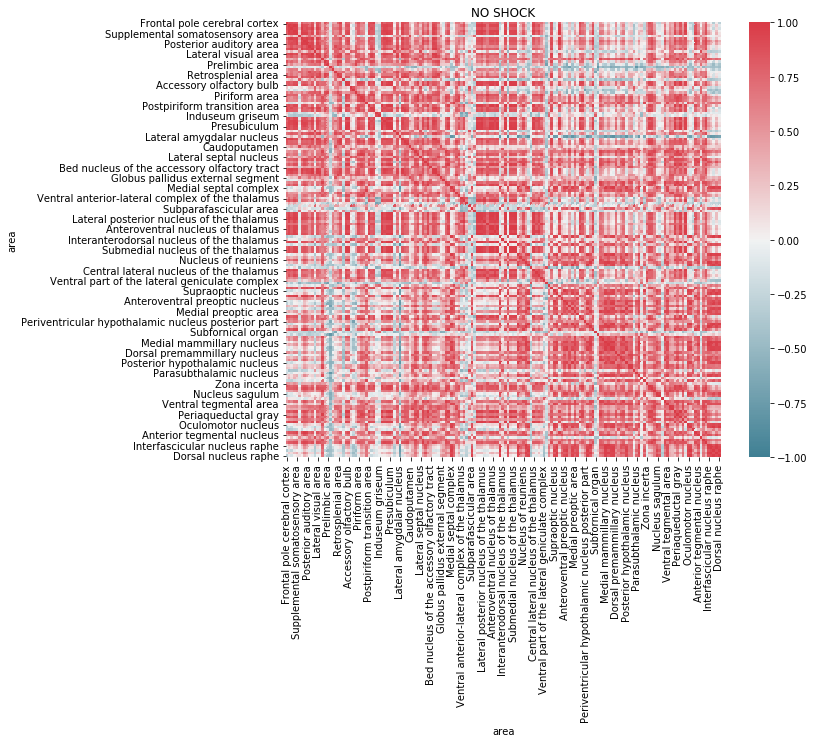

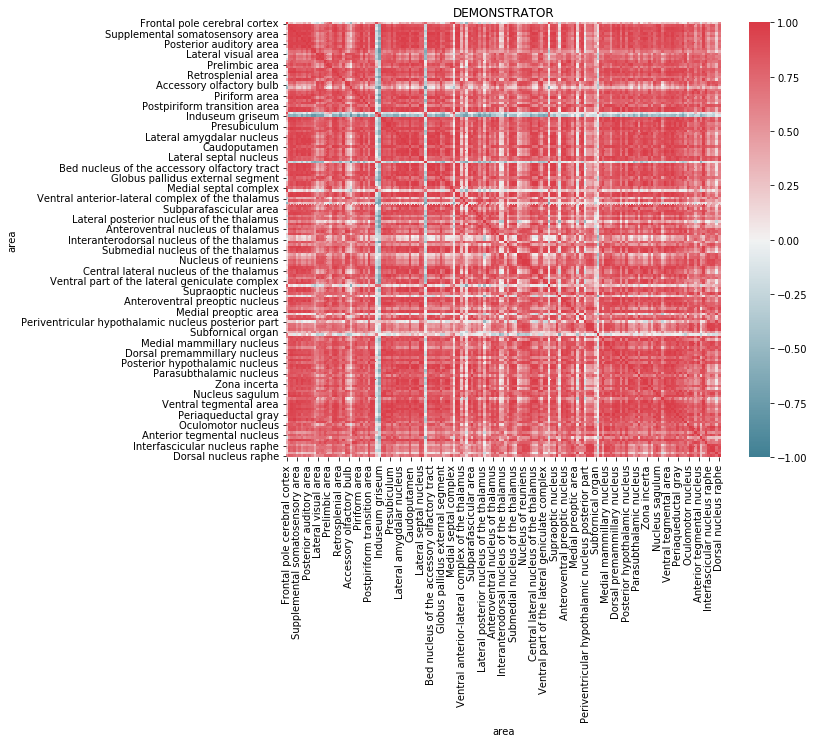

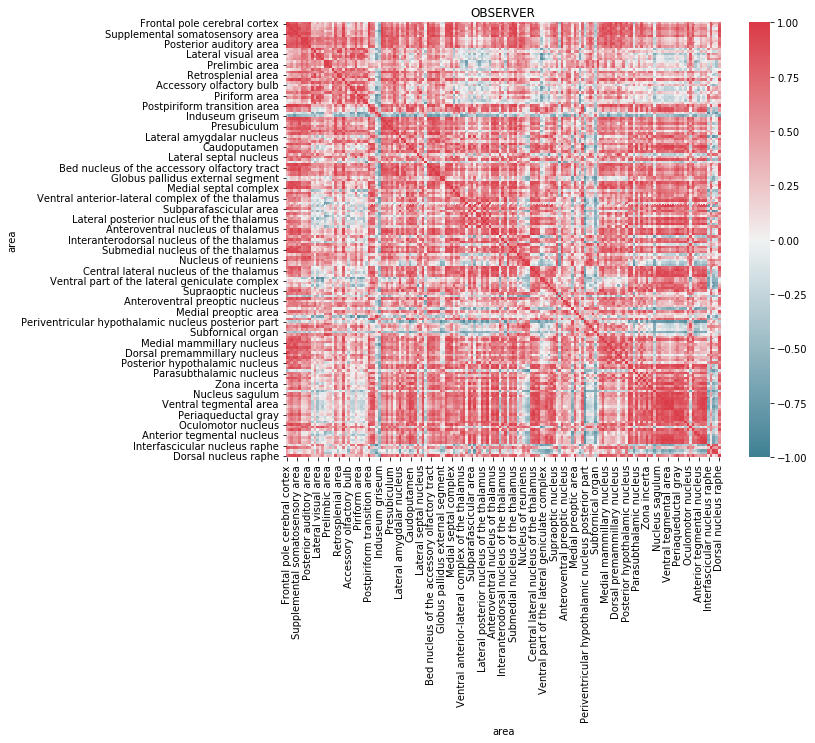

In [20]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_noshock_ncells),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('NO SHOCK')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_demonstrator_ncells),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('DEMONSTRATOR')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_observer_ncells),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('OBSERVER')

# Calculate t-tests density across groups per area

In [21]:
df_noshock_density, df_demonstrator_density, df_observer_density = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='density')
df_ttest_density = ace.test_across_groups([df_noshock_density,
                                          df_demonstrator_density,
                                          df_observer_density],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'],
                                        test='mannwhitneyu')
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_density = df_ttest_density.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])

In [22]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='density',
                       test='mannwhitneyu',
                      alpha=0.05).to_csv('significant_areas_non_param_test_density.csv',
                                        index=False)
df_ttest_density.to_csv('df_nonparametrictest_density.csv', index=False)

# Calculate t-tests energy across groups per area

In [23]:
df_noshock_energy, df_demonstrator_energy, df_observer_energy = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='energy')
df_ttest_energy = ace.test_across_groups([df_noshock_energy,
                                          df_demonstrator_energy,
                                          df_observer_energy],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'],
                                        test='mannwhitneyu')
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])


In [24]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='energy',
                       test='mannwhitneyu',
                      alpha=0.05).to_csv('significant_areas_non_param_test_energy.csv',
                                        index=False)
df_ttest_ncells.to_csv('df_nonparametrictest_energy.csv', index=False)

In [25]:
df_ttest_not_null_energy.sort_values(
    by='pval_noshock_vs_demonstrator')[['area', 'pval_noshock_vs_demonstrator']][0:20].set_index('area')

,pval_noshock_vs_demonstrator
area,
Lateral strip of striatum,0.00108251
Substantia nigra lateral part,0.00108251
Intercollicular nucleus,0.00108251
Suprachiasmatic preoptic nucleus,0.00108251
Anterior hypothalamic area,0.00108251
Nucleus circularis,0.00108251
Pineal body,0.00108251
Retroethmoid nucleus,0.00108251
Anterior olfactory nucleus,0.0107254


In [26]:
df_ttest_not_null_energy.sort_values(
    by='pval_noshock_vs_observer')[['area', 'pval_noshock_vs_observer']][0:45].set_index('area')

,pval_noshock_vs_observer
area,
Lateral strip of striatum,0.00108251
Substantia nigra lateral part,0.00108251
Intercollicular nucleus,0.00108251
Anterior hypothalamic area,0.00108251
Nucleus circularis,0.00108251
Pineal body,0.00108251
Suprachiasmatic preoptic nucleus,0.00108251
Retroethmoid nucleus,0.00108251
Posterolateral visual area,0.00164726


In [27]:
df_ttest_not_null_energy.sort_values(
    by='pval_demonstrator_vs_observer')[['area', 'pval_demonstrator_vs_observer']][0:10].set_index('area')

,pval_demonstrator_vs_observer
area,
Suprachiasmatic preoptic nucleus,0.00108251
Substantia nigra lateral part,0.00108251
Retroethmoid nucleus,0.00108251
Anterior hypothalamic area,0.00108251
Nucleus circularis,0.00108251
Lateral strip of striatum,0.00108251
Intercollicular nucleus,0.00108251
Pineal body,0.00108251
Bed nucleus of the anterior commissure,0.0797025


In [28]:
corr_matrix_noshock_energy = ace.cross_corr(df_noshock_energy)
corr_matrix_demonstrator_energy = ace.cross_corr(df_demonstrator_energy)
corr_matrix_observer_energy = ace.cross_corr(df_observer_energy)

Text(0.5, 1.0, 'OBSERVER')

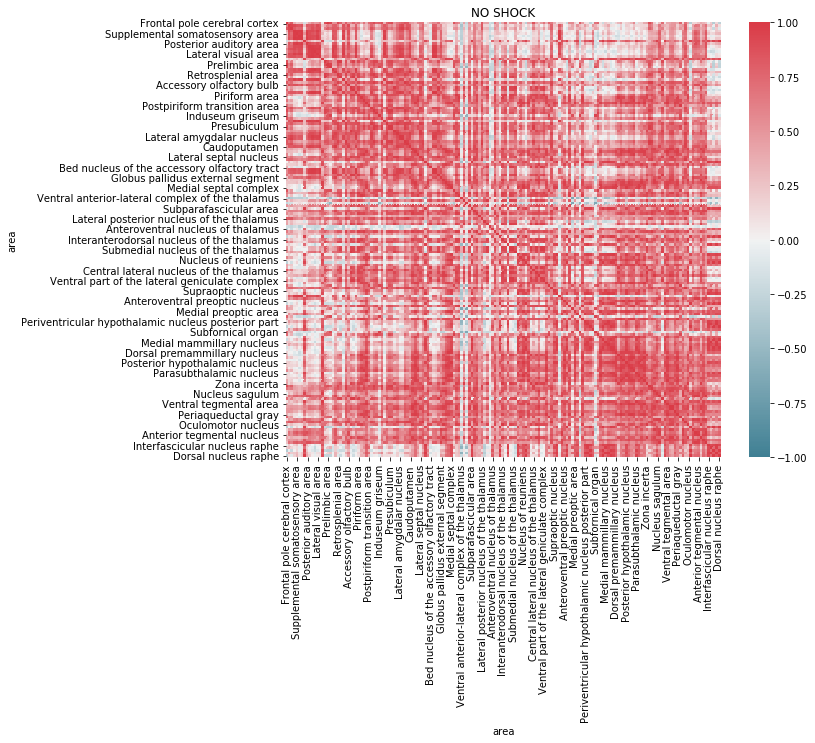

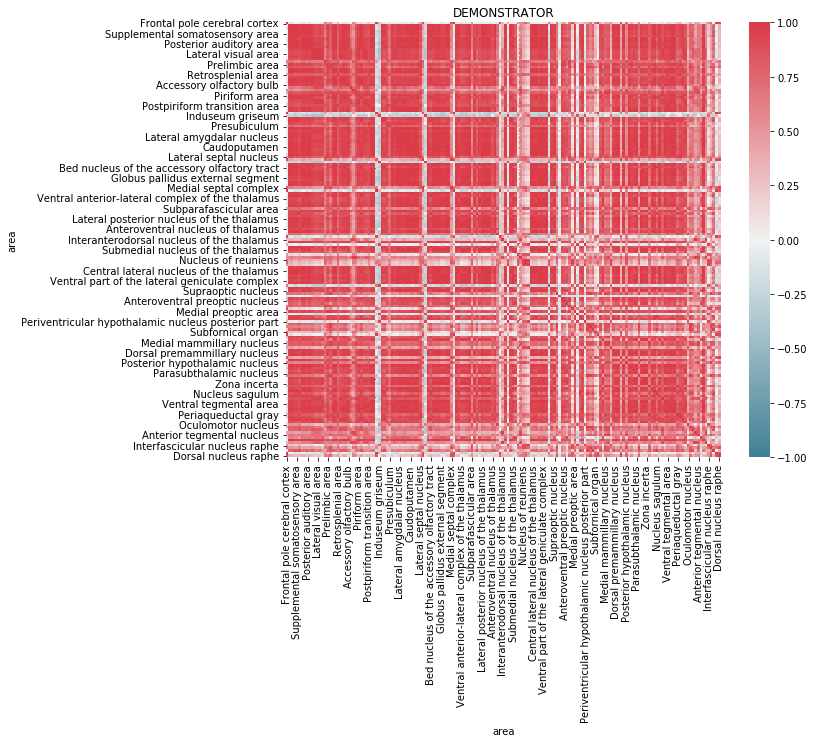

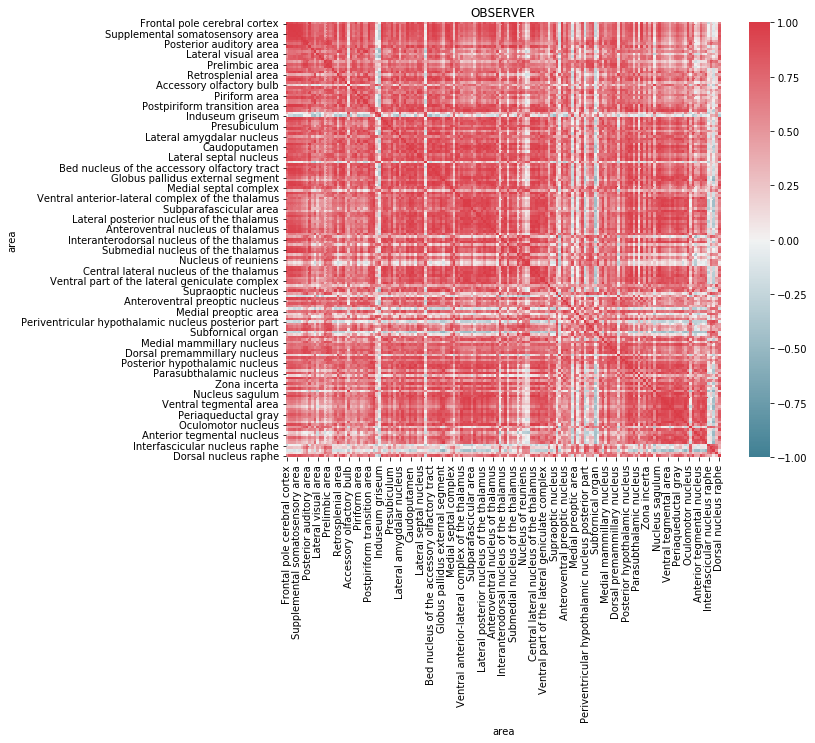

In [29]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_noshock_energy),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('NO SHOCK')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_demonstrator_energy),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('DEMONSTRATOR')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_observer_energy),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('OBSERVER')

# Calculate relative density

In [30]:
df_noshock_rd, df_demonstrator_rd, df_observer_rd = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='relative_density')
df_ttest_rd = ace.test_across_groups([df_noshock_rd,
                                          df_demonstrator_rd,
                                          df_observer_rd],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'],
                                        test='mannwhitneyu')
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_rd = df_ttest_rd.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])

In [31]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='relative_density',
                       test='mannwhitneyu',
                      alpha=0.05).to_csv('significant_areas_non_param_test_relative_density.csv',
                                        index=False)
df_ttest_ncells.to_csv('df_nonparametrictest_relative_density.csv', index=False)

In [32]:
df_ttest_not_null_rd.sort_values(
    by='pval_noshock_vs_demonstrator')[['area', 'pval_noshock_vs_demonstrator']][0:30].set_index('area')

,pval_noshock_vs_demonstrator
area,
Lateral strip of striatum,0.00108251
Anterior hypothalamic area,0.00108251
Nucleus circularis,0.00108251
Pineal body,0.00108251
Suprachiasmatic preoptic nucleus,0.00108251
Intercollicular nucleus,0.00108251
Cortical amygdalar area,0.00108251
Retroethmoid nucleus,0.00108251
Substantia nigra lateral part,0.00108251


In [33]:
df_ttest_not_null_rd.sort_values(
    by='pval_noshock_vs_observer')[['area', 'pval_noshock_vs_observer']][0:20].set_index('area')

,pval_noshock_vs_observer
area,
Lateral strip of striatum,0.00108251
Pineal body,0.00108251
Retroethmoid nucleus,0.00108251
Substantia nigra lateral part,0.00108251
Nucleus circularis,0.00108251
Anterior hypothalamic area,0.00108251
Suprachiasmatic preoptic nucleus,0.00108251
Intercollicular nucleus,0.00108251
Posterolateral visual area,0.00246895


In [34]:
df_ttest_not_null_rd.sort_values(
    by='pval_demonstrator_vs_observer')[['area', 'pval_demonstrator_vs_observer']][0:20].set_index('area')

,pval_demonstrator_vs_observer
area,
Pineal body,0.00108251
Nucleus circularis,0.00108251
Anterior hypothalamic area,0.00108251
Intercollicular nucleus,0.00108251
Retroethmoid nucleus,0.00108251
Suprachiasmatic preoptic nucleus,0.00108251
Substantia nigra lateral part,0.00108251
Lateral strip of striatum,0.00108251
Bed nucleus of the anterior commissure,0.020346


In [35]:
corr_matrix_noshock_rd = ace.cross_corr(df_noshock_rd)
corr_matrix_demonstrator_rd = ace.cross_corr(df_demonstrator_rd)
corr_matrix_observer_rd = ace.cross_corr(df_observer_rd)

Text(0.5, 1.0, 'OBSERVER')

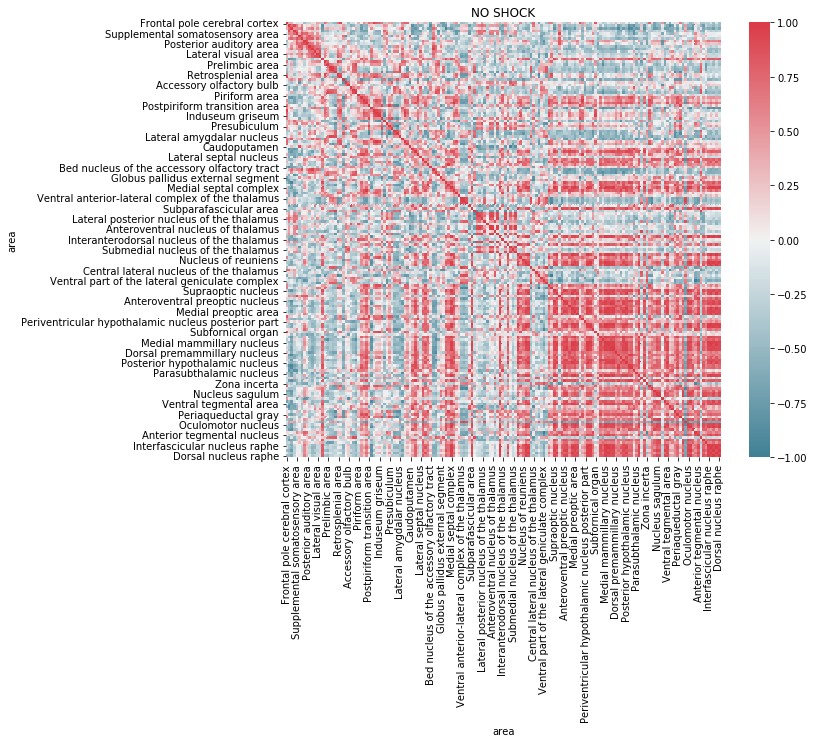

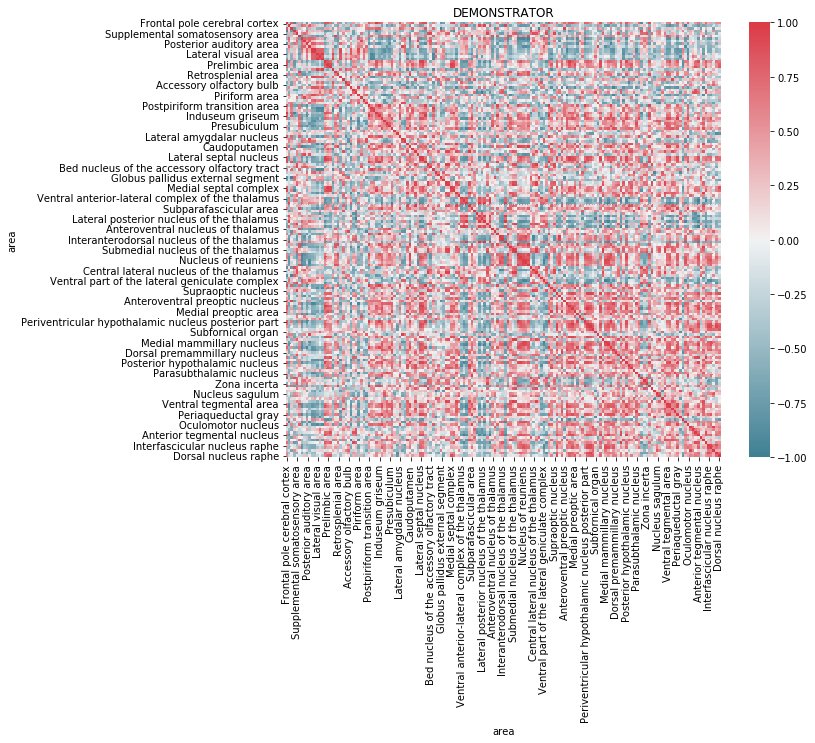

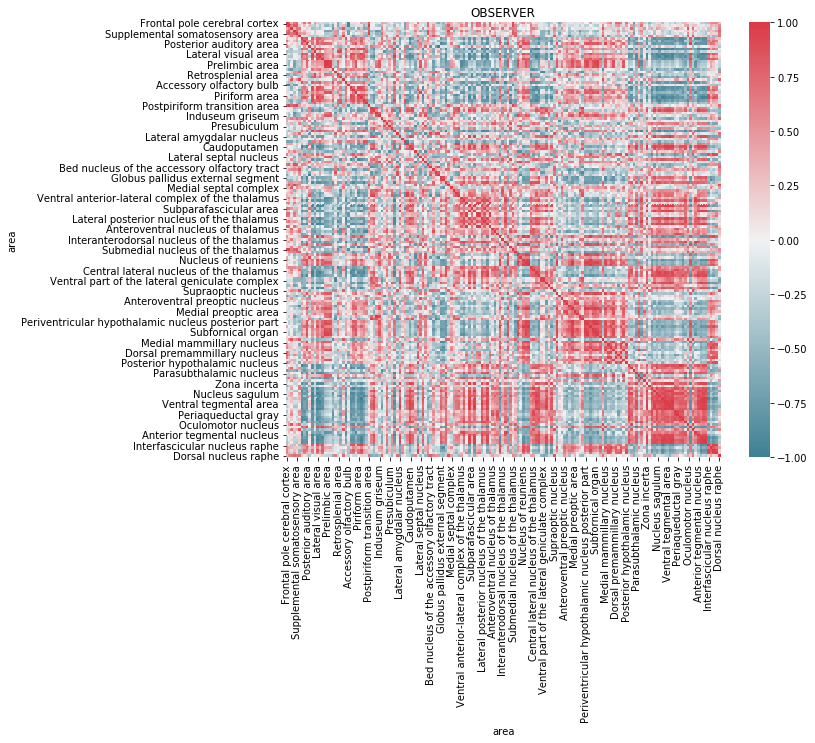

In [36]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_noshock_rd),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('NO SHOCK')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_demonstrator_rd),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('DEMONSTRATOR')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_observer_rd),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('OBSERVER')

# Correlation with behavior

In [39]:
#load behavioral data and removing mouse 12
behavior = pd.read_excel('/home/stella/Documents/Torino/projects/ClearMap2_PISA/ClearMap/Scripts/results/subs_FOS_EC.xlsx', 
                         index_col=0,
     engine='openpyxl').drop(11)

In [40]:
behavior

,cage,label,sex,geno,role,EC_amp_0,EC_lat_0,mouse
0,CLT_5,000,M,WT,NOS,1.055338,2.05,BL15noshock
1,CLT_3,R00,M,WT,NOS,-0.796098,3.00,BL7noshock
2,CLT_3,0R0,M,WT,OBS,1.067573,2.40,BL2observer
3,CLT_9,R00,F,WT,OBS,1.114847,1.70,BL21observer
4,CLT_1,000,F,WT,OBS,3.932445,1.00,BL8observer
5,CLT_7,00R,F,WT,OBS,9.881270,1.70,BL18observer
6,CLT_2,0R0,F,WT,NOS,-0.534185,1.20,BL1noshock
7,CLT_7,000,F,WT,NOS,0.140642,2.05,BL19noshock
8,CLT_6,0R0,M,WT,OBS,1.250897,2.80,BL10observer
9,CLT_6,00B,M,WT,NOS,0.920259,1.15,BL11noshock


In [41]:
behavior_noshock = behavior[behavior['role'] == 'NOS'][['EC_amp_0', 'EC_lat_0', 'mouse']].reset_index(drop=True)
behavior_observer = behavior[behavior['role'] == 'OBS'][['EC_amp_0', 'EC_lat_0', 'mouse']].reset_index(drop=True)

In [42]:
behavior_observer

,EC_amp_0,EC_lat_0,mouse
0,1.067573,2.40,BL2observer
1,1.114847,1.70,BL21observer
2,3.932445,1.00,BL8observer
3,9.881270,1.70,BL18observer
4,1.250897,2.80,BL10observer
5,2.324617,1.40,BL5observer
6,1.573428,2.05,BL16observer


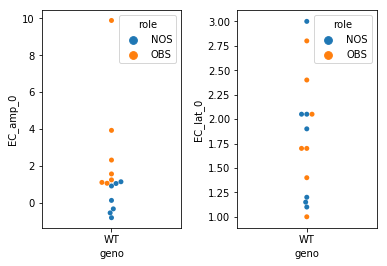

In [43]:
# make plot
fig, axes = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.4)
# Draw a categorical scatterplot to show each observation
sns.swarmplot(data=behavior, y="EC_amp_0",x='geno',
                   hue="role", ax=axes[0])
sns.swarmplot(data=behavior, y="EC_lat_0",x='geno',
                   hue="role", ax=axes[1])

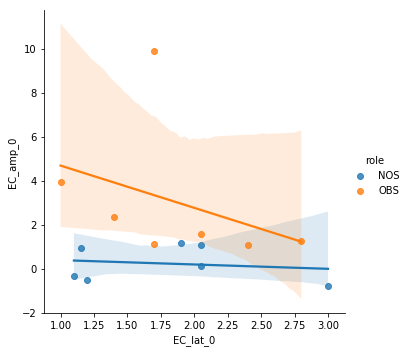

In [44]:
g = sns.lmplot(
    data=behavior,
    x="EC_lat_0", y="EC_amp_0", hue="role",
    height=5
)

# Plots corr tests

In [45]:
significant_areas = ace.select_significant_areas(dictionary=dict_results_across_mice, 
                                             experimental_groups=experimental_groups, 
                                             batch='PISA',
                                             test='mannwhitneyu', 
                                             threshold_test=0.05,
                                             threshold_pls=2.56,
                                             value_test='density', 
                                             value_pls='relative_density')

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [46]:
areas_ttest_acronyms = set([volumes[volumes['safe_name']==area]['acronym'].values[0] \
                            for area in significant_areas])

In [47]:
#reorder behavioral data based on df_group
behavior_observer = behavior_observer.set_index('mouse').\
            loc[df_observer_density.set_index('area').columns.to_list(), :].reset_index()
behavior_noshock = behavior_noshock.set_index('mouse').\
            loc[df_noshock_density.set_index('area').columns.to_list(), :].reset_index()

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


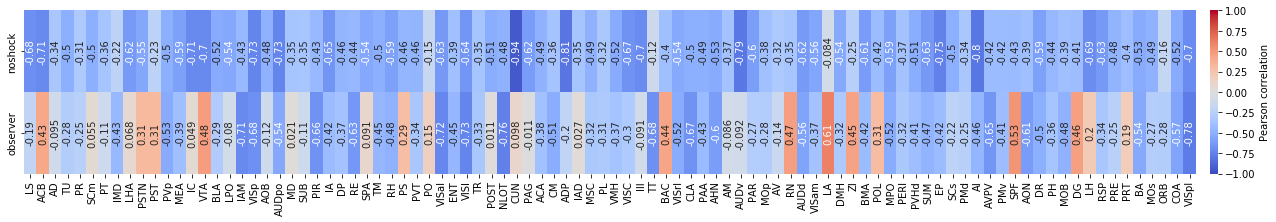

In [48]:
corr_ncells, pvalue = ace.compute_corr_pvalue(dfs_groups=[df_noshock_density, df_observer_density], 
                                   group_labels=['noshock', 'observer'],
                                   volumes=volumes, 
                                   behavioral_data=[behavior_noshock['EC_amp_0'],
                                                      behavior_observer['EC_amp_0']],
                                   significant_areas=list(areas_ttest_acronyms))
# put X if pvalue is significant
fig, axes = plt.subplots(figsize=(25,3))
sns.heatmap(corr_ncells, ax=axes, cmap='coolwarm', vmin=-1, vmax=+1, 
                             cbar_kws={'label': 'Pearson correlation',"pad":0.01},
           annot=True, annot_kws={'rotation': 90})

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


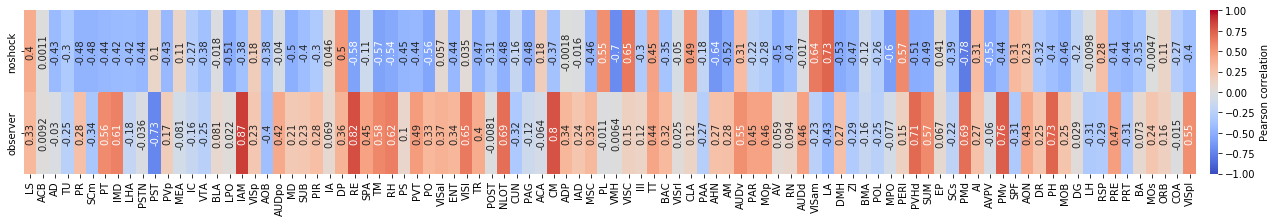

In [49]:
corr_ncells, pvalue = ace.compute_corr_pvalue(dfs_groups=[df_noshock_density, df_observer_density], 
                                   group_labels=['noshock', 'observer'],
                                   volumes=volumes, 
                                   behavioral_data=[behavior_noshock['EC_lat_0'],
                                                      behavior_observer['EC_lat_0']],
                                   significant_areas=list(areas_ttest_acronyms))
# put X if pvalue is significant
fig, axes = plt.subplots(figsize=(25,3))
sns.heatmap(corr_ncells, ax=axes, cmap='coolwarm', vmin=-1, vmax=+1, 
                             cbar_kws={'label': 'Pearson correlation',"pad":0.01},
           annot=True, annot_kws={'rotation': 90})

# Check delta tra correlazioni nei gruppi + distribuzioni correlazioni tra gruppi

Text(0.5, 1.0, 'Observer')

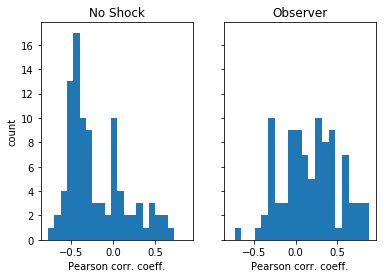

In [50]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
axes[0].hist(corr_ncells.T['noshock'], bins=20)
axes[1].hist(corr_ncells.T['observer'], bins=20)
axes[0].set_ylabel('count')
axes[0].set_xlabel('Pearson corr. coeff.')
axes[1].set_xlabel('Pearson corr. coeff.')
axes[0].set_title('No Shock')
axes[1].set_title('Observer')

# Plots correlation density vs EC_amp_0 delle aree viste da ste

In [51]:
aree_ste = ['Agranular insular area',
           'Retrosplenial area',
           'Anterior olfactory nucleus',
           'Postsubiculum',
           'Presubiculum',
           'Claustrum',
           'Endopiriform nucleus',
           'Basolateral amygdalar nucleus',
           'Intercalated amygdalar nucleus',
           'Medial amygdalar nucleus',
           'Lateral hypothalamic area',
           'Superior colliculus sensory related',
           'Inferior colliculus']

## For pupil amplitude

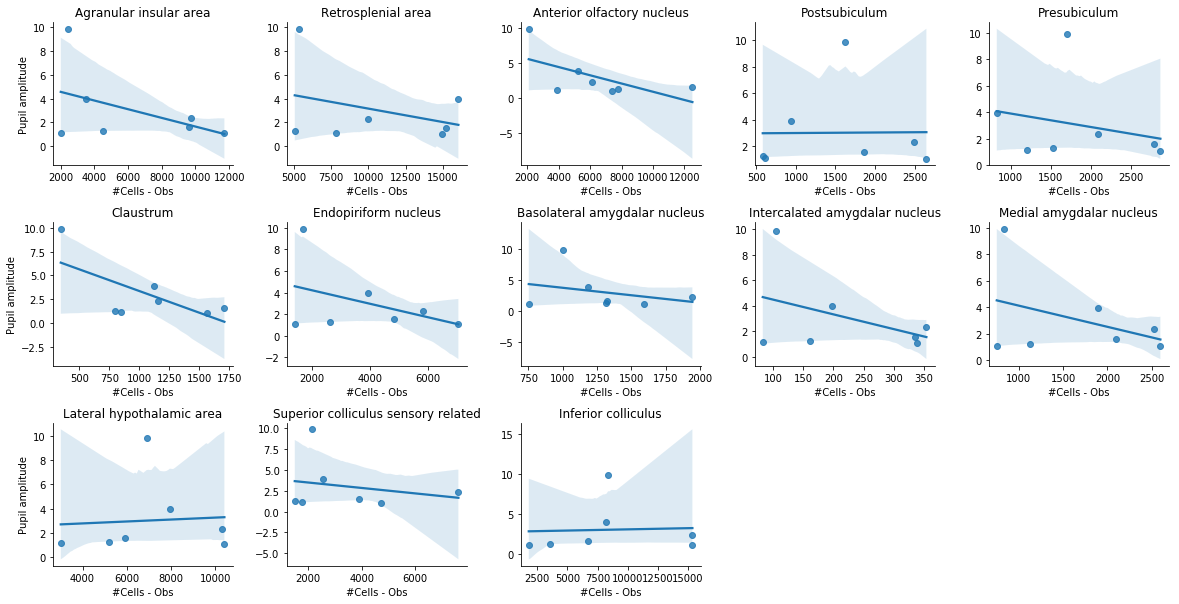

In [52]:
fig, axes  = plt.subplots(3,5, figsize=(20,10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
for i, area in enumerate(aree_ste):
    data = pd.DataFrame(columns=['n_cells', 'behavior', 'mouse'])
    data['n_cells'] = df_observer_ncells.set_index('area').T[area].values
    data['subject'] = df_observer_ncells.set_index('area').T[area].index
    data['behavior'] = [behavior_observer[behavior_observer['mouse']==mouse]["EC_amp_0"].item() \
                        for mouse in data['subject'].values]
    g = sns.regplot(data=data, x='n_cells', 
                   y='behavior', ax=axes.flat[i],
                   fit_reg=True)
    axes.flat[i].set_title(area)
    axes.flat[i].set_title(area)
    axes.flat[i].spines['top'].set_visible(False)
    axes.flat[i].spines['right'].set_visible(False)
    axes.flat[i].set_xlabel("#Cells - Obs")
    if i not in [0,5,10]:
        axes.flat[i].set_ylabel("")
    else:
        axes.flat[i].set_ylabel("Pupil amplitude")
fig.delaxes(axes.flat[13])
fig.delaxes(axes.flat[14])
plt.savefig('correlation_pupil_amplitude.png')
plt.savefig('correlation_pupil_amplitude.svg')

## For pupil latency

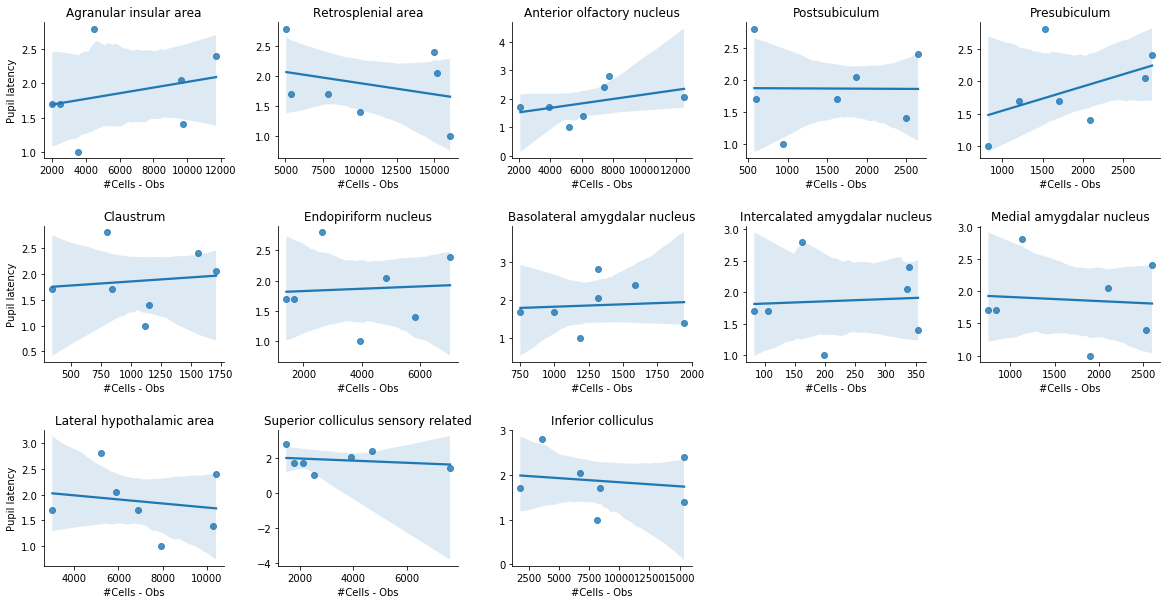

In [53]:
fig, axes  = plt.subplots(3,5, figsize=(20,10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for i, area in enumerate(aree_ste):
    data = pd.DataFrame(columns=['n_cells', 'behavior'])
    data['n_cells'] = df_observer_ncells.set_index('area').T[area].values
    data['subject'] = df_observer_ncells.set_index('area').T[area].index
    data['behavior'] = [behavior_observer[behavior_observer['mouse']==mouse]["EC_lat_0"].item() \
                        for mouse in data['subject'].values]
    g = sns.regplot(data=data, x='n_cells', 
                   y='behavior', ax=axes.flat[i])
    axes.flat[i].set_title(area)
    axes.flat[i].set_title(area)
    axes.flat[i].spines['top'].set_visible(False)
    axes.flat[i].spines['right'].set_visible(False)
    axes.flat[i].set_xlabel("#Cells - Obs")
    if i not in [0,5,10]:
        axes.flat[i].set_ylabel("")
    else:
        axes.flat[i].set_ylabel("Pupil latency")
fig.delaxes(axes.flat[13])
fig.delaxes(axes.flat[14])
plt.savefig('correlation_pupil_latency.png')
plt.savefig('correlation_pupil_latency.svg')

#  Overlap aree attivate (noshock vs observer) vs (noshock vs demonstrator)

In [54]:
area_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_noshock_vs_demonstrator']<0.05]['area'].values])
area_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_noshock_vs_observer']<0.05]['area'].values])

In [55]:
# intersection significant areas with relative density
area_noshock_vs_demonstrator.intersection(area_noshock_vs_observer) 

{'AHA',
 'AON',
 'BMA',
 'CLA',
 'COA',
 'CP',
 'ENT',
 'EP',
 'FS',
 'GPe',
 'IAM',
 'InCo',
 'LSS',
 'NC',
 'PIN',
 'PIR',
 'PPN',
 'PSCH',
 'RE',
 'REth',
 'RN',
 'SNl',
 'TT',
 'VISal',
 'VISl',
 'VISp',
 'VISpl'}

In [56]:
# areas that are significant in demonstrator but not in observer
area_noshock_vs_demonstrator.difference(area_noshock_vs_observer) 

{'AUDpo',
 'AUDv',
 'IA',
 'IMD',
 'LT',
 'MOB',
 'MRN',
 'NLOT',
 'ORB',
 'PP',
 'RH',
 'RR',
 'RT',
 'SI',
 'SNc',
 'SNr',
 'TR'}

In [57]:
# areas significant in observer and not in demonstrator
area_noshock_vs_observer.difference(area_noshock_vs_demonstrator) 

{'CEA', 'DG', 'DR', 'POST', 'PR', 'RSP', 'VISam', 'VISrl'}

# Histograms of counts of all measures across significant areas

## relative density

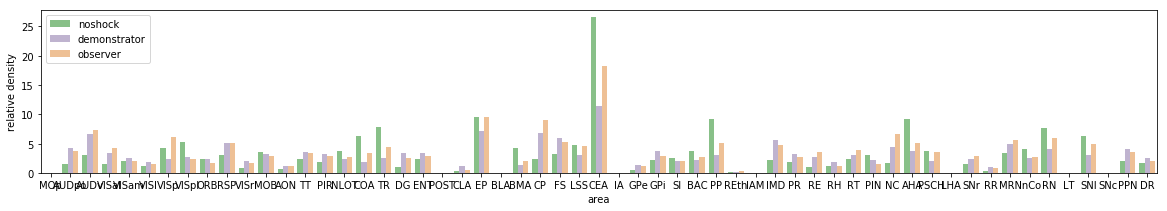

In [58]:
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_demonstrator_vs_observer']<0.05]['area'].values]))
areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'relative density', 'group'])
fam = pd.DataFrame(columns=['area', 'relative density', 'group'])
unfam = pd.DataFrame(columns=['area', 'relative density', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['relative density'] = [df_noshock_rd.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['relative density'] = [df_demonstrator_rd.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['relative density'] = [df_observer_rd.set_index('area').loc[area].mean() for area in areas_ttest]
without_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, gridspec_kw={'hspace':0.05}, figsize=(20,3))
sns.barplot(
    data=without_father,
    x="area", y="relative density", hue="group", palette="Accent", ax=ax)
ax.legend().set_title('')

## number of cells

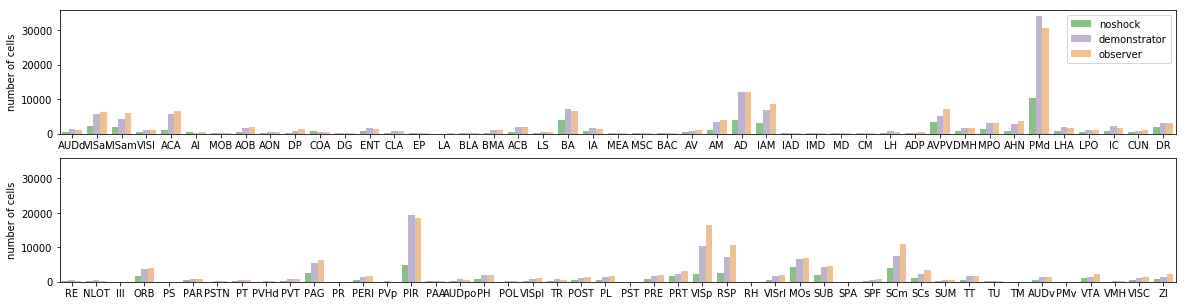

In [59]:
##### stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values]))[:45]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['number of cells'] = [df_noshock_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['number of cells'] = [df_demonstrator_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['number of cells'] = [df_observer_ncells.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

#stack 2

areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values]))[45:]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['number of cells'] = [df_noshock_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['number of cells'] = [df_demonstrator_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['number of cells'] = [df_observer_ncells.set_index('area').loc[area].mean() for area in areas_ttest]
without_father2 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=2, gridspec_kw={'hspace':0.2}, figsize=(20,5), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax[0])
ax[0].set_xlabel('')
sns.barplot(
    data=without_father2,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax[1])
ax[1].set_xlabel('')
ax[1].legend_.remove()
ax[0].legend().set_title('')

## density

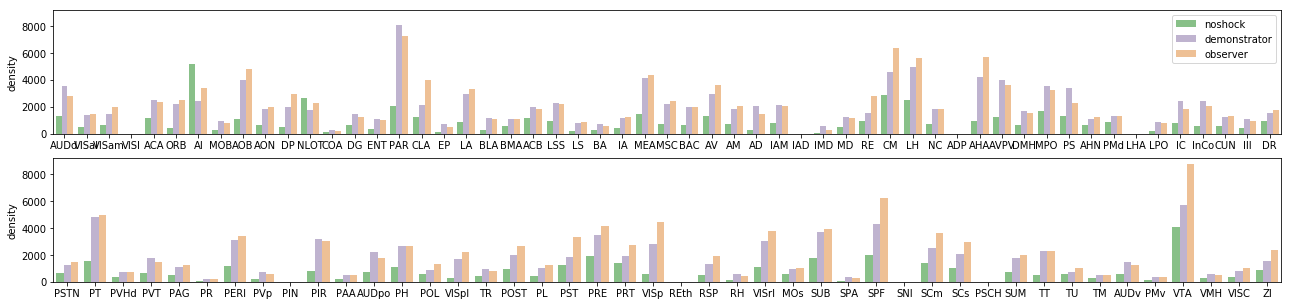

In [60]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_demonstrator_vs_observer']<0.05]['area'].values]))[:55]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'density', 'group'])
fam = pd.DataFrame(columns=['area', 'density', 'group'])
unfam = pd.DataFrame(columns=['area', 'density', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['density'] = [df_noshock_density.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['density'] = [df_demonstrator_density.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['density'] = [df_observer_density.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

#stack 2

areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_demonstrator_vs_observer']<0.05]['area'].values]))[55:]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]


control = pd.DataFrame(columns=['area', 'density', 'group'])
fam = pd.DataFrame(columns=['area', 'density', 'group'])
unfam = pd.DataFrame(columns=['area', 'density', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['density'] = [df_noshock_density.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['density'] = [df_demonstrator_density.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['density'] = [df_observer_density.set_index('area').loc[area].mean() for area in areas_ttest]
without_father2 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=2, gridspec_kw={'hspace':0.2}, figsize=(22,5), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="density", hue="group", palette="Accent", ax=ax[0])
ax[0].set_xlabel('')
sns.barplot(
    data=without_father2,
    x="area", y="density", hue="group", palette="Accent", ax=ax[1])
ax[1].legend_.remove()
ax[1].set_xlabel('')
ax[0].legend().set_title('')

## energy

Text(0.5, 0, '')

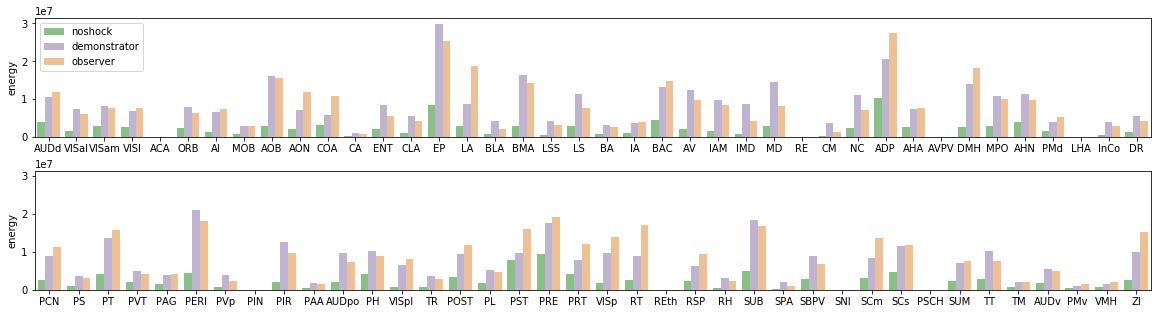

In [61]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_demonstrator_vs_observer']<0.05]['area'].values]))[:40]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['energy'] = [df_noshock_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['energy'] = [df_demonstrator_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['energy'] = [df_observer_energy.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

#stack 2

areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_demonstrator_vs_observer']<0.05]['area'].values]))[40:]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]


control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['energy'] = [df_noshock_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['energy'] = [df_demonstrator_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['energy'] = [df_observer_energy.set_index('area').loc[area].mean() for area in areas_ttest]
without_father2 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=2, gridspec_kw={'hspace':0.28}, figsize=(20,5), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="energy", hue="group", palette="Accent", ax=ax[0])
ax[0].set_xlabel('')
ax[0].legend().set_title('')
sns.barplot(
    data=without_father2,
    x="area", y="energy", hue="group", palette="Accent", ax=ax[1])
ax[1].legend_.remove()
ax[1].set_xlabel('')

# Intersection significant areas (ttest ncells vs energy vs dens vs rel_dens) 
for 
- control vs observer 
- control vs demonstrator
- observer vs demonstrator

In [62]:
ncells_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_ncells[
    df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values])

energy_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_energy[
    df_ttest_not_null_energy['pval_noshock_vs_observer']<0.05]['area'].values])

rd_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_noshock_vs_observer']<0.05]['area'].values])

density_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_density[
    df_ttest_not_null_density['pval_noshock_vs_observer']<0.05]['area'].values])

print(len(ncells_noshock_vs_observer), len(energy_noshock_vs_observer), len(rd_noshock_vs_observer), len(density_noshock_vs_observer))
ncells_noshock_vs_observer.intersection(
    energy_noshock_vs_observer).intersection(
    rd_noshock_vs_observer).intersection(
    density_noshock_vs_observer)

90 76 35 98


{'AON',
 'BMA',
 'CLA',
 'COA',
 'DR',
 'ENT',
 'EP',
 'IAM',
 'PIR',
 'POST',
 'RE',
 'RSP',
 'TT',
 'VISal',
 'VISam',
 'VISl',
 'VISp',
 'VISpl'}

In [63]:
ncells_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_ncells[
    df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values])

energy_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_energy[
    df_ttest_not_null_energy['pval_noshock_vs_demonstrator']<0.05]['area'].values])

rd_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_noshock_vs_demonstrator']<0.05]['area'].values])

density_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_density[
    df_ttest_not_null_density['pval_noshock_vs_demonstrator']<0.05]['area'].values])

print(len(ncells_noshock_vs_demonstrator), len(energy_noshock_vs_demonstrator), len(rd_noshock_vs_demonstrator), len(density_noshock_vs_demonstrator))
ncells_noshock_vs_demonstrator.intersection(
    energy_noshock_vs_demonstrator).intersection(
    rd_noshock_vs_demonstrator).intersection(
    density_noshock_vs_demonstrator)

45 39 44 53


{'AON',
 'BMA',
 'CLA',
 'COA',
 'ENT',
 'EP',
 'IAM',
 'IMD',
 'MOB',
 'ORB',
 'PIR',
 'RE',
 'RH',
 'TR',
 'TT',
 'VISl',
 'VISp',
 'VISpl'}

In [64]:
ncells_demonstrator_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_ncells[
    df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values])

energy_demonstrator_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_energy[
    df_ttest_not_null_energy['pval_demonstrator_vs_observer']<0.05]['area'].values])

rd_demonstrator_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_demonstrator_vs_observer']<0.05]['area'].values])

density_demonstrator_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_density[
    df_ttest_not_null_density['pval_demonstrator_vs_observer']<0.05]['area'].values])

print(len(ncells_demonstrator_vs_observer), len(energy_demonstrator_vs_observer), len(rd_demonstrator_vs_observer), len(density_demonstrator_vs_observer))
ncells_demonstrator_vs_observer.intersection(
    energy_demonstrator_vs_observer).intersection(
    rd_demonstrator_vs_observer).intersection(
    density_demonstrator_vs_observer)

1 8 15 9


set()

# Saving data

In [ ]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_PISA.npy', 
                                   allow_pickle=True).item()
# reformat dictionary and subjects
old_keys = list(dict_results_across_mice.keys())
for key in old_keys:
    group = key.split('_')[-1] if key.split('_')[-1][-1]!='2' else key.split('_')[-1][:-1]
    number = key.split('_')[0]
    new_key = 'BL'+number+'_'+group
    dict_results_across_mice[new_key] = dict_results_across_mice[key]
    del dict_results_across_mice[key]
    
#remove BL12_noshock due to biased number of cells
del dict_results_across_mice['BL12_noshock']
subjects = list(dict_results_across_mice.keys())


In [ ]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects,
                                                group_labels=['noshock','demonstrator', 'observer'])

## Saving tables cell counts

In [ ]:
df_noshock_ncells, df_demonstrator_ncells, df_observer_ncells = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [ ]:
df_noshock_ncells.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/df_noshock_ncells.csv')
df_demonstrator_ncells.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/df_demonstrator_ncells.csv')
df_observer_ncells.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/df_observer_ncells.csv')

## Saving t-test results

In [ ]:
df_noshock_ncells, df_demonstrator_ncells, df_observer_ncells = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups([df_noshock_ncells,
                                          df_demonstrator_ncells,
                                          df_observer_ncells],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'])
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])
df_ttest_not_null_ncells.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/df_ttest_ncells.csv')

## Saving correlation matrices

In [ ]:
# saving correlation matrices
corr_matrix_noshock_ncells = ace.cross_corr(df_noshock_ncells)
corr_matrix_demonstrator_ncells = ace.cross_corr(df_demonstrator_ncells)
corr_matrix_observer_ncells = ace.cross_corr(df_observer_ncells)
corr_matrix_noshock_ncells.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_noshock_ncells.csv')
corr_matrix_demonstrator_ncells.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_demonstrator_ncells.csv')
corr_matrix_observer_ncells.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_observer_ncells.csv')

## Saving energy counts + tests 

In [ ]:
df_noshock_energy, df_demonstrator_energy, df_observer_energy = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='energy')
df_ttest_energy = ace.test_across_groups([df_noshock_energy,
                                          df_demonstrator_energy,
                                          df_observer_energy],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'])
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])
df_noshock_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/df_noshock_energy.csv')
df_demonstrator_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/df_demonstrator_energy.csv')
df_observer_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/df_observer_energy.csv')
df_ttest_not_null_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/df_ttest_energy.csv')

In [ ]:
corr_matrix_noshock_energy = ace.cross_corr(df_noshock_energy)
corr_matrix_demonstrator_energy = ace.cross_corr(df_demonstrator_energy)
corr_matrix_observer_energy = ace.cross_corr(df_observer_energy)
corr_matrix_noshock_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_noshock_energy.csv')
corr_matrix_demonstrator_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_demonstrator_energy.csv')
corr_matrix_observer_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_observer_energy.csv')

In [ ]:
## Saving relative density + tests

In [ ]:
corr_matrix_noshock_energy = ace.cross_corr(df_noshock_energy)
corr_matrix_demonstrator_energy = ace.cross_corr(df_demonstrator_energy)
corr_matrix_observer_energy = ace.cross_corr(df_observer_energy)
corr_matrix_noshock_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_noshock_energy.csv')
corr_matrix_demonstrator_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_demonstrator_energy.csv')
corr_matrix_observer_energy.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_observer_energy.csv')

In [ ]:
corr_matrix_noshock_rd = ace.cross_corr(df_noshock_rd)
corr_matrix_demonstrator_rd = ace.cross_corr(df_demonstrator_rd)
corr_matrix_observer_rd = ace.cross_corr(df_observer_rd)
corr_matrix_noshock_rd.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_noshock_rd.csv')
corr_matrix_demonstrator_rd.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_demonstrator_rd.csv')
corr_matrix_observer_rd.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_matrix_observer_rd.csv')

## Saving correlation with behavior

In [ ]:
#load behavioral data and removing mouse 12
behavior = pd.read_excel('/home/stella/Documents/Torino/projects/SexualImprinting/PISA/subs_FOS_EC.xlsx', 
                         index_col=0).drop(11)
behavior_noshock = behavior[behavior['role'] == 'NOS'][['EC_amp_0', 'EC_lat_0']]
behavior_observer = behavior[behavior['role'] == 'OBS'][['EC_amp_0', 'EC_lat_0']]

In [ ]:
areas_ttest_ncells = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values]))
areas_ttest_acronyms = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest_ncells])

In [ ]:
significant_areas = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest_ncells]
corr_ncells, pvalue = ace.compute_corr_pvalue(dfs_groups=[df_noshock_ncells, df_observer_ncells], 
                                   group_labels=['noshock', 'observer'],
                                   volumes=volumes, 
                                   behavioral_data=[behavior_noshock['EC_amp_0'],
                                                      behavior_observer['EC_amp_0']],
                                   significant_areas=significant_areas)
corr_ncells.to_csv(
    '/home/stella/Documents/Torino/projects/SexualImprinting/PISA/results/corr_ncells_behavior.csv')